In [1]:
import os
import time
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#from scipy.stats import chi2_contingency
from statsmodels.stats.contingency_tables import Table2x2
from statsmodels.stats.multitest import multipletests
from scipy.special import erf
from lifelines import CoxTimeVaryingFitter
import cmdstanpy
from cmdstanpy import CmdStanModel
import arviz as az

from multipathogen_sero import (
    simulate_infections,
    simulate_infections_seroreversion,
    simulate_infections_survivor,
    simulate_infections_discrete,
    simulation_to_regression_df,
    simulation_to_survey_long,
    survey_long_to_wide,
    get_constant_foi,
    get_constant_foi_survivor
)

from multipathogen_sero.config import PROJ_ROOT, STAN_DIR, MODEL_FITS_DIR
# # Prepend to PATH (Windows uses ; as separator)
# current_path = os.environ.get('PATH', '')
# new_path = ';'.join(CMDSTAN_PATHS) + ';' + current_path
# os.environ['PATH'] = new_path


2025-09-08 17:16:20.305 | INFO     | multipathogen_sero.config:<module>:12 - PROJ_ROOT path is: /home/ayan/sero/multipathogen-sero


# Simulation

In [ ]:
n_people = 1000 #number of individuals n
np.random.seed(42)  # For reproducibility
t_max=100
birth_times = np.random.uniform(0, t_max, size=n_people)  # Random birth times for individuals
n_pathogens=2 #number of pathogens K

pathogen_names = [f'Pathogen {i}' for i in range(1,n_pathogens+1)]  # Names for pathogens
#foi_list = [get_exponential_foi(0, 1) for k, pathogen_name in enumerate(pathogen_names)]

baseline_hazards = [0.1*k for k in range(1,n_pathogens+1)]  # Example baseline hazards
foi_list = [
    get_constant_foi(a=baseline_hazards[k]) for k in range(n_pathogens)
]
survivor_list = [
    get_constant_foi_survivor(a=baseline_hazards[k]) for k in range(n_pathogens)
]
log_frailty_covariance = np.ones((n_pathogens, n_pathogens)) * 0.1
true_beta_scale = 3.0
true_proportion_interactions = 0.1
interaction_indicator = np.random.binomial(1, true_proportion_interactions, size=(n_pathogens, n_pathogens))
interaction_indicator[np.arange(n_pathogens), np.arange(n_pathogens)] = 0
beta_mat = np.random.normal(0, true_beta_scale, size=(n_pathogens, n_pathogens)) * interaction_indicator
interaction_mat = np.exp(beta_mat)

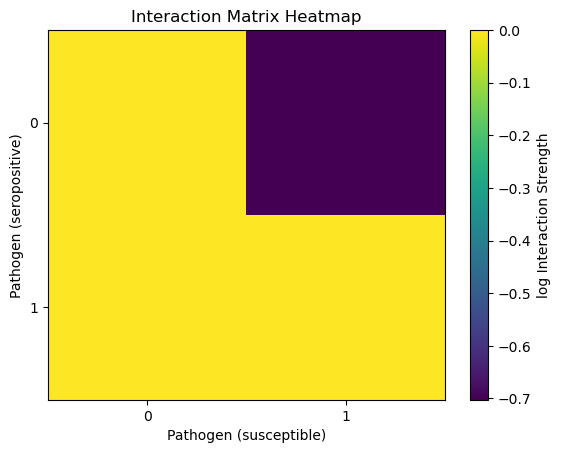

In [ ]:

np.random.seed(42)  # For reproducibility
#plot the interaction matrix as a heatmap
plt.imshow(np.log(interaction_mat), cmap='viridis', aspect='auto')
plt.ylabel('Pathogen (seropositive)')
plt.xlabel('Pathogen (susceptible)')
plt.xticks(ticks=np.arange(n_pathogens), labels=np.arange(0, n_pathogens))
plt.yticks(ticks=np.arange(n_pathogens), labels=np.arange(0, n_pathogens))
plt.colorbar(label='log Interaction Strength')
plt.title('Interaction Matrix Heatmap')
plt.show()

In [ ]:
start = time.time()
simulate_infections_df = simulate_infections_seroreversion(
    n_people,
    n_pathogens,
    foi_list,
    interaction_mat=interaction_mat,
    birth_times=birth_times,
    log_frailty_covariance=log_frailty_covariance,
    end_times=t_max,
    max_fois=None,
    random_seed=42
)
print(f"simulate_infections_seroreversion took {time.time() - start:.3f} seconds")


simulate_infections_seroreversion took 0.117 seconds


# Bayesian Cox Regression

In [63]:
#########################
k_infector = 2       # Infecting pathogen to analyze
n_people_subsample = min(1000, n_people)  # Subsample size for analysis
#########################


regression_df_for_pathogen_k = simulation_to_regression_df(
    simulate_infections_df,
    k_infector=k_infector,  # Set to None to include all pathogens, or specify a specific pathogen index
    t_max=t_max
)
regression_df_for_pathogen_k_subsampled = regression_df_for_pathogen_k[regression_df_for_pathogen_k["individual"]<=n_people_subsample]

In [64]:
stan_data = {
    "N": n_people_subsample, # Number of individuals
    "P": n_pathogens - 1, # Number of covariates
    "n_rows": len(regression_df_for_pathogen_k_subsampled), # Number of observation rows
    "T_L": regression_df_for_pathogen_k_subsampled["start_time"].values,
    "T_R": regression_df_for_pathogen_k_subsampled["stop_time"].values,
    "event": regression_df_for_pathogen_k_subsampled["event"].values,
    "person_id": regression_df_for_pathogen_k_subsampled["individual"].values,
    "X": regression_df_for_pathogen_k_subsampled.filter(like='serostatus_').values, # get the data for columns starting with serostatus_,
    "beta_prior_setting": 2, # 0 for no prior, 1 for Laplace prior, 2 for spike and slab prior
    "laplace_scale": 1.0,  # scale for Laplace prior when beta_prior_setting == 1
    "slab_scale": 1.0,  # Scale for the slab in spike and slab prior
    "spike_scale": 0.05,  # Scale for the spike in spike and slab prior
    "pi": 0.1 # Inclusion probability for the spike and slab prior
}

In [65]:
model = CmdStanModel(
    stan_file= STAN_DIR / "infection_histories.stan"
)

fit = model.sample(
    data=stan_data,
    chains=4,
    iter_sampling=500,
    iter_warmup=500,
    parallel_chains=4,
    seed=123
)

17:45:16 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

17:45:17 - cmdstanpy - INFO - CmdStan done processing.


Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

Rank-normalized split R-hat values satisfactory for all parameters.

Processing complete, no problems detected.

                        Mean      MCSE    StdDev       MAD           5%  \
lp__            -2590.190000  0.047289  1.281850  0.963690 -2592.750000   
baseline_hazard     0.189211  0.000591  0.011266  0.011331     0.172445   
beta_raw[1]         0.049356  0.001678  0.049216  0.043635    -0.024012   
beta_raw[2]        -0.164759  0.004701  0.097691  0.105142    -0.331785   
beta[1]             0.049356  0.001678  0.049216  0.043635    -0.024012   
...                      ...       ...       ...       ...          ...   
log_lik[996]       -2.644480  0.000085

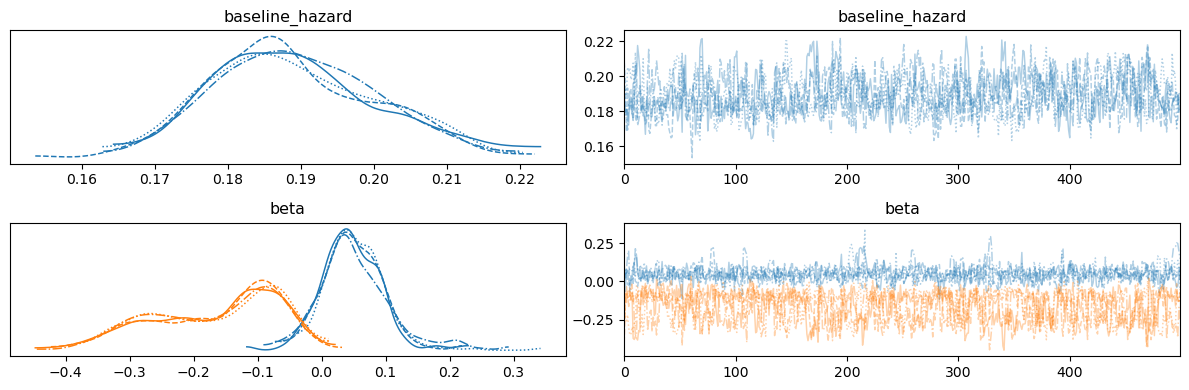

In [66]:
# Print summary
print(fit.diagnose())
print(fit.summary())

# Check R-hat and ESS
df_summary = fit.summary()
print("Any R-hat > 1.01?", (df_summary["R_hat"] > 1.01).any())
print("Any ESS < 400?", (df_summary["ESS_bulk"] < 400).any())

# Optional: convert to ArviZ for easier plotting
idata = az.from_cmdstanpy(posterior=fit)

# Plot trace plots
az.plot_trace(idata, var_names=["baseline_hazard", "beta"])
plt.tight_layout()
plt.show()

True baseline hazard: 0.2


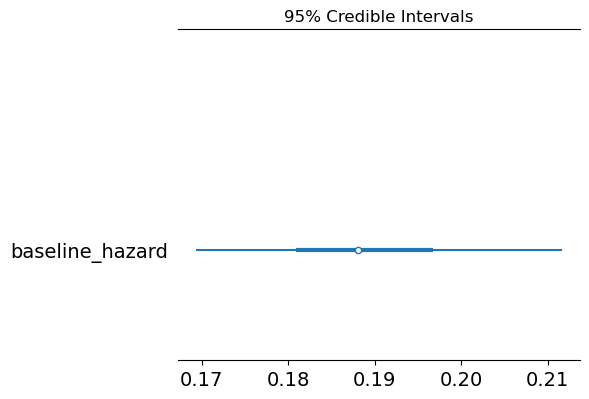

True beta coefficients: [-0.52516981 -0.        ]


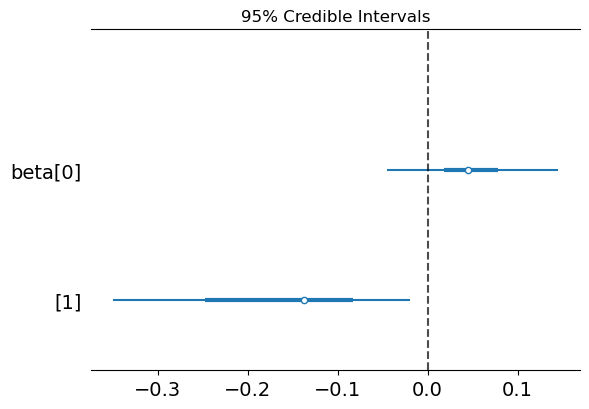

In [67]:
print(f"True baseline hazard: {baseline_hazards[k_infector-1]}")
az.plot_forest(idata, var_names=["baseline_hazard"], 
               hdi_prob=0.95, combined=True)
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

print(f"True beta coefficients: {np.concatenate([beta_mat[:k_infector-1, k_infector-1],beta_mat[k_infector:, k_infector-1]])}")

ax = az.plot_forest(idata, var_names=["beta"], 
                    hdi_prob=0.95, combined=True)
plt.axvline(0, color='black', linestyle='--', alpha=0.7)
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

# serological data

In [4]:
survey_every = 10.0
survey_times = {
    i+1: np.insert(
        survey_every * np.arange(np.floor(birth_times[i]/survey_every)+1, np.floor(t_max/survey_every)+1),
        0, birth_times[i]
    )
    for i in range(n_people)
}

def get_survey_bounds(row):
    times = survey_times[row["individual"]]
    i = np.searchsorted(times, row["time"], side="left")
    if i == len(times):
        raise NotImplementedError(f"No next survey time ≥ {row['time']} for individual {row['individual']}")
    if i == 0:
        raise NotImplementedError(f"No last survey time < {row['time']} for individual {row['individual']}")
    next_time = times[i]
    last_time = times[i - 1]
    return pd.Series({"last_survey_time": last_time, "next_survey_time": next_time})

# infections
infection_intervals = simulate_infections_df.query("event == 'seroconversion'").copy()
infection_intervals["pathogen"] = infection_intervals["pathogen"].astype(int)
infection_intervals[["last_survey_time", "next_survey_time"]] = infection_intervals.apply(get_survey_bounds, axis=1)
last_survey_times = infection_intervals["last_survey_time"].values
next_survey_times = infection_intervals["next_survey_time"].values
infection_person_ids = infection_intervals["individual"].values
infection_pathogen_ids = infection_intervals["pathogen"].values

# lookup
gets_infected = np.zeros((n_people, n_pathogens), dtype=bool)
lookup_indices = np.zeros((n_people, n_pathogens), dtype=int)
for counter, row in enumerate(infection_intervals.itertuples()):
    gets_infected[row.individual - 1, row.pathogen - 1] = True
    lookup_indices[row.individual - 1, row.pathogen - 1] = counter+1 #1-indexed
num_infections = gets_infected.sum()

# noninfections
num_noninfections = n_people * n_pathogens - num_infections
indices = np.argwhere(gets_infected == 0)
lookup_indices[gets_infected == 0] = np.arange(1, num_noninfections + 1) #1-indexed
noninfection_person_ids = indices[:, 0] + 1  # Convert to 1-based indexing
noninfection_pathogen_ids = indices[:, 1] + 1  # Convert to 1-based indexing
censoring_times = np.array([survey_times[i][-1] for i in noninfection_person_ids])


In [5]:
"""
data {
    int<lower=1> N;                         // Number of individuals
    array[N] real birth_times;               // Birth time for each individual
    int<lower=1> K;                         // Number of pathogens
    array[N,K] int<lower=0, upper=1> gets_infected; // 0 = always negative, 1 = seroconverter
    int<lower=0> num_infections; // Number of infection times (seroconversions)
    int<lower=0> num_noninfections; // Number of uninfected individuals (seronegative)
    array[N,K] int<lower=1, upper=N*K> lookup_indices; // Index to look up individual, pathogen infection times in their respective (1-indexed) arrays
    array[num_infections] real lower_bound_times; // Lower bound of seroconversion time
    array[num_infections] real upper_bound_times; // Upper bound of seroconversion time
    array[num_infections] int<lower=1, upper=N> infection_person_ids; // Individual ID for each seroconversion (should be 1-indexed)
    array[num_infections] int<lower=1, upper=K> infection_pathogen_ids; // Pathogen ID for each seroconversion (should be 1-indexed)
    array[num_noninfections] real censoring_times; // Lower bound of seroconversion time
    array[num_noninfections] int<lower=1, upper=N> noninfection_person_ids; // Individual ID for each seronegative individual (should be 1-indexed)
    array[num_noninfections] int<lower=1, upper=K> noninfection_pathogen_ids; // Pathogen ID for each seronegative individual (should be 1-indexed)
    real <lower=0> time_to_immunity; // timescale for immunity to kick in
                                     // not scientific, just to make the likelihood continuous wrt latent infection times 
    real <lower=0> beta_scale; // scale for Laplace prior on log hazard ratios
}
"""
# TODO: write tests
stan_data = {
    "N": n_people,
    "K": n_pathogens,
    "birth_times": birth_times,
    "gets_infected": gets_infected,
    "num_infections": num_infections,
    "num_noninfections": num_noninfections,
    "lookup_indices": lookup_indices,
    "lower_bound_times": last_survey_times,
    "upper_bound_times": next_survey_times,
    "infection_person_ids": infection_person_ids,
    "infection_pathogen_ids": infection_pathogen_ids,
    "censoring_times": censoring_times,
    "noninfection_person_ids": noninfection_person_ids,
    "noninfection_pathogen_ids": noninfection_pathogen_ids,
    "time_to_immunity": 0.05,  # timescale for immunity to kick in
    "beta_scale": 1.0,  # scale for Laplace prior on log hazard ratios
    "log_frailty_scale_scale": 0.01,
    "log_frailty_corr_shape": 5.0,  # shape parameter for the log frailty covariance prior
}

print(birth_times[0])
print(gets_infected[0])
print(lookup_indices[0])
print(last_survey_times[lookup_indices[0][gets_infected[0]]-1])
print(next_survey_times[lookup_indices[0][gets_infected[0]]-1])
print(infection_person_ids[lookup_indices[0][gets_infected[0]]-1])
print(infection_pathogen_ids[lookup_indices[0][gets_infected[0]]-1])
print(censoring_times[lookup_indices[0][~gets_infected[0]]-1])
print(noninfection_person_ids[lookup_indices[0][~gets_infected[0]]-1])
print(noninfection_pathogen_ids[lookup_indices[0][~gets_infected[0]]-1])

37.454011884736246
[ True  True]
[2 1]
[40. 40.]
[50. 50.]
[1 1]
[1 2]
[]
[]
[]


In [6]:
model = CmdStanModel(
    stan_file= STAN_DIR / "multiplex_serology_frailty.stan"
)

In [8]:
chains = 4
iter_sampling = 150
iter_warmup = 150
parallel_chains = 4
seed = 123
max_treedepth = 15
fit = model.sample(
    data=stan_data,
    chains=chains,
    iter_sampling=iter_sampling,
    iter_warmup=iter_warmup,
    parallel_chains=parallel_chains,
    seed=seed,
    max_treedepth=max_treedepth,
    show_progress=True,
    show_console=False
)

17:22:59 - cmdstanpy - INFO - Requested 4 parallel_chains but only 1 required, will run all chains in parallel.
17:22:59 - cmdstanpy - INFO - Chain [1] start processing


Chain [1] method = sample (Default)
Chain [1] sample
Chain [1] num_samples = 50
Chain [1] num_warmup = 50
Chain [1] save_warmup = false (Default)
Chain [1] thin = 1 (Default)
Chain [1] adapt
Chain [1] engaged = true (Default)
Chain [1] gamma = 0.05 (Default)
Chain [1] delta = 0.8 (Default)
Chain [1] kappa = 0.75 (Default)
Chain [1] t0 = 10 (Default)
Chain [1] init_buffer = 75 (Default)
Chain [1] term_buffer = 50 (Default)
Chain [1] window = 25 (Default)
Chain [1] save_metric = false (Default)
Chain [1] algorithm = hmc (Default)
Chain [1] hmc
Chain [1] engine = nuts (Default)
Chain [1] nuts
Chain [1] max_depth = 15
Chain [1] metric = diag_e (Default)
Chain [1] metric_file =  (Default)
Chain [1] stepsize = 1 (Default)
Chain [1] stepsize_jitter = 0 (Default)
Chain [1] num_chains = 1 (Default)
Chain [1] id = 1 (Default)
Chain [1] data
Chain [1] file = /tmp/tmplbwjjr4k/t8_wi3nd.json
Chain [1] init = 2 (Default)
Chain [1] random
Chain [1] seed = 123
Chain [1] output
Chain [1] file = /tmp/tmp

17:25:04 - cmdstanpy - INFO - Chain [1] done processing
17:25:04 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'multiplex_serology_frailty.stan', line 124, column 4 to column 50)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'multiplex_serology_frailty.stan', line 124, column 4 to column 50)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'multiplex_serology_frailty.stan', line 124, column 4 to column 50)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'multiplex_serology_frailty.stan', line 124, column 4 to column 50)
	Exception: lkj_corr_cholesky_lpdf: Random variable[2] is 0, but must be positive! (in 'multiplex_serology_frailty.stan', line 124, column 4 to column 50)


Chain [1] 
Chain [1] Elapsed Time: 51.324 seconds (Warm-up)
Chain [1] 73.038 seconds (Sampling)
Chain [1] 124.362 seconds (Total)
Chain [1] 
Chain [1] 


In [10]:
import pickle
import time
name = f"fit_{int(time.time())}"

fit.save_csvfiles(
    MODEL_FITS_DIR / name
)
fit_metadata = {
    "time": int(time.time()),
    "data": {
        "n_people": n_people,
        "n_pathogens": n_pathogens,
        "baseline_hazards": baseline_hazards,
        "survey_every": survey_every,
        "t_max": t_max,
        "log_frailty_covariance": log_frailty_covariance,
        "beta_mat": beta_mat,
    },
    "model": "multiplex_serology",
    "model_params": {
        "chains": chains,
        "iter_sampling": iter_sampling,
        "iter_warmup": iter_warmup,
        "seed": seed,
        "max_treedepth": max_treedepth
    },
    "notes": ""
}
with open(PROJ_ROOT / "model_fits" / name / "metadata.pkl", "wb") as f:
    pickle.dump(fit_metadata, f)

NameError: name 'beta_mat' is not defined

In [ ]:
# with open(PROJ_ROOT / "model_fits" / name / "metadata.pkl", "rb") as f:
#     fit_metadata_read = pickle.load(f)
# fit_metadata_read

{'model': 'multiplex_serology',
 'n_people': 100,
 'n_pathogens': 5,
 'baseline_hazards': [0.04, 0.08, 0.12, 0.16, 0.2],
 'survey_every': 10.0,
 't_max': 100,
 'notes': 'all max tree depth'}

Checking sampler transitions treedepth.
Treedepth satisfactory for all transitions.

Checking sampler transitions for divergences.
No divergent transitions found.

Checking E-BFMI - sampler transitions HMC potential energy.
E-BFMI satisfactory.

Rank-normalized split effective sample size satisfactory for all parameters.

The following parameters had rank-normalized split R-hat greater than 1.01:
  baseline_hazards[1], baseline_hazards[2], betas[1], betas[2], infection_times[1], infection_times[2], infection_times[3], infection_times[7], infection_times[8], infection_times[9], infection_times[10], infection_times[11], infection_times[12], infection_times[14], infection_times[15], infection_times[16], infection_times[20], infection_times[21], infection_times[22], infection_times[23], infection_times[25], infection_times[27], infection_times[28], infection_times[29], infection_times[32], infection_times[33], infection_times[35], infection_times[37], infection_times[39], infection_times[4

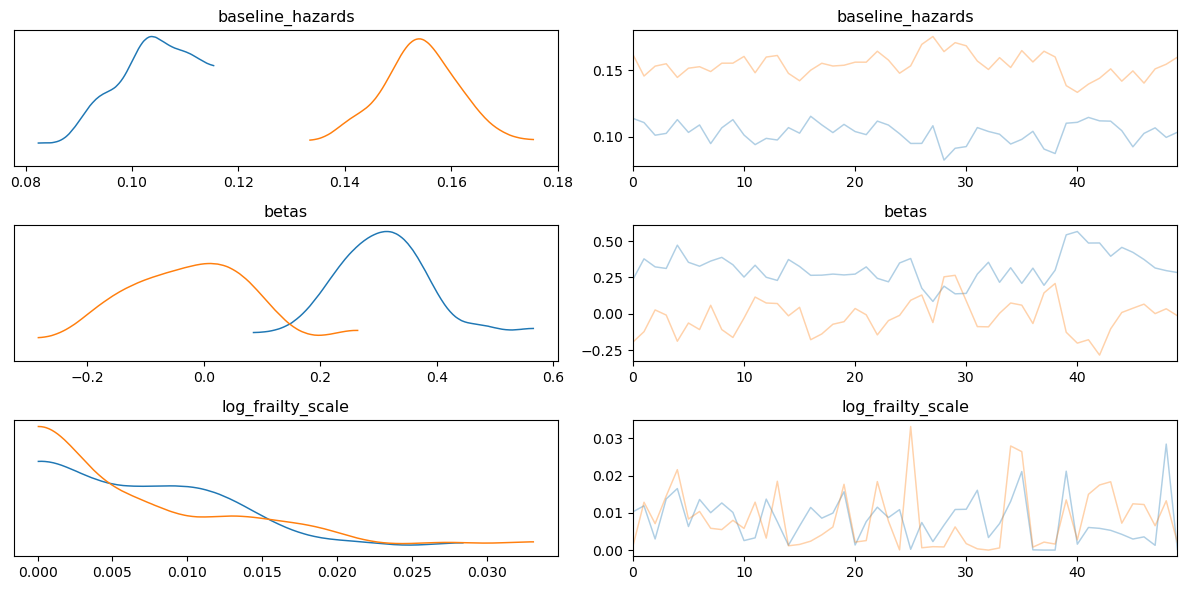

In [11]:
# Print summary
print(fit.diagnose())
print(fit.summary())

# Check R-hat and ESS
df_summary = fit.summary()
print("Any R-hat > 1.01?", (df_summary["R_hat"] > 1.01).any())
print("Any ESS < 400?", (df_summary["ESS_bulk"] < 400).any())

# Optional: convert to ArviZ for easier plotting
idata = az.from_cmdstanpy(posterior=fit)

# Plot trace plots
az.plot_trace(idata, var_names=["baseline_hazards", "betas", "log_frailty_scale"])
plt.tight_layout()
plt.show()

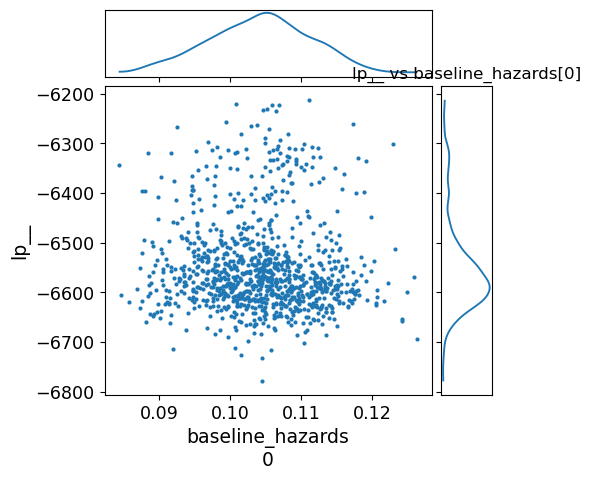

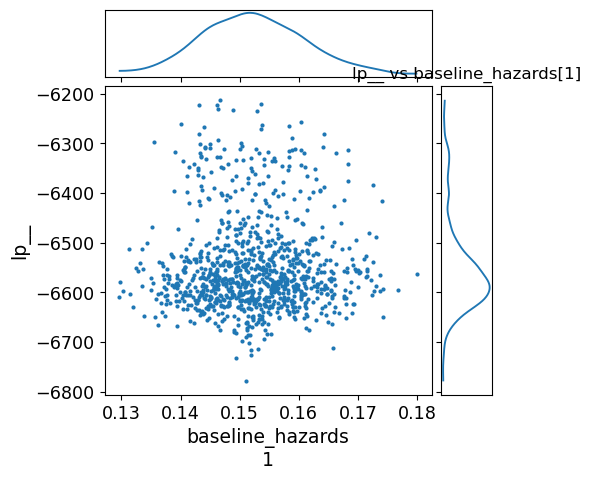

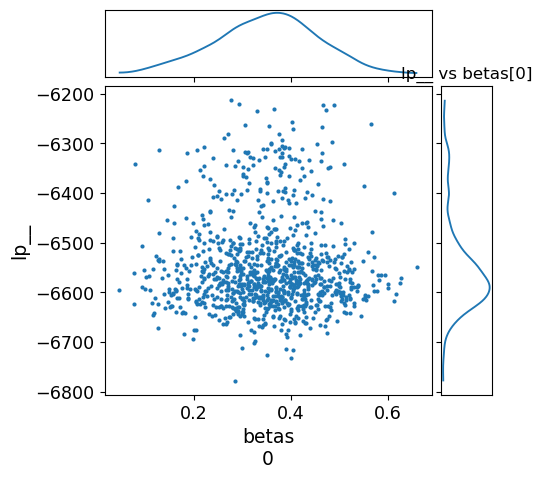

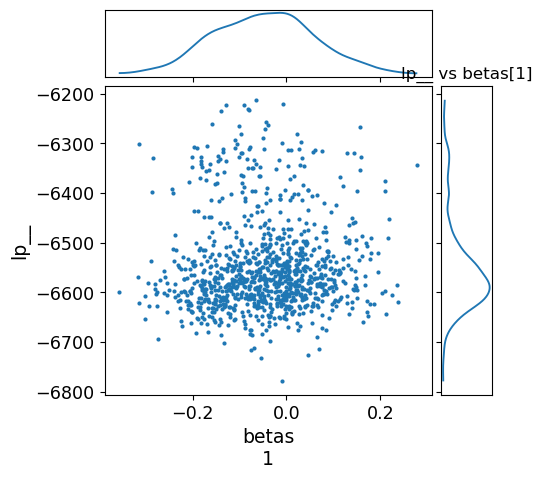

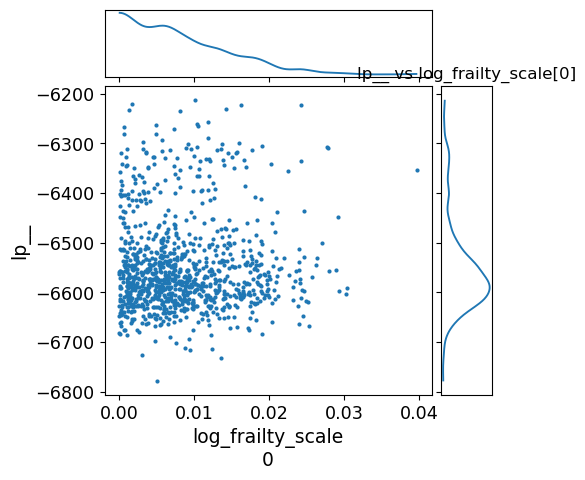

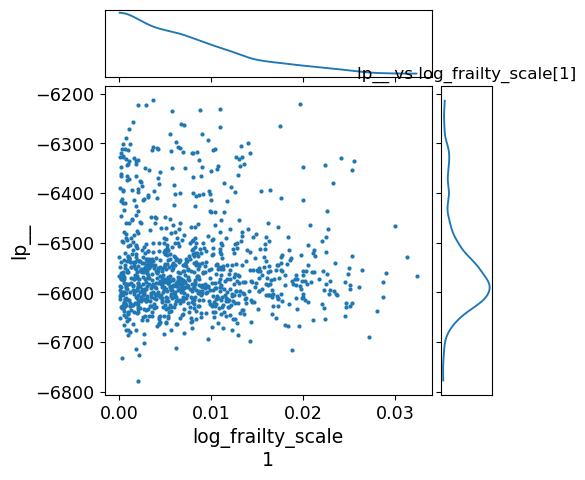

/home/ayan/anaconda3/envs/multipathogen-sero/lib/python3.11/site-packages/arviz/stats/density_utils.py:488: UserWarning: Your data appears to have a single value or no finite values
  warnings.warn("Your data appears to have a single value or no finite values")


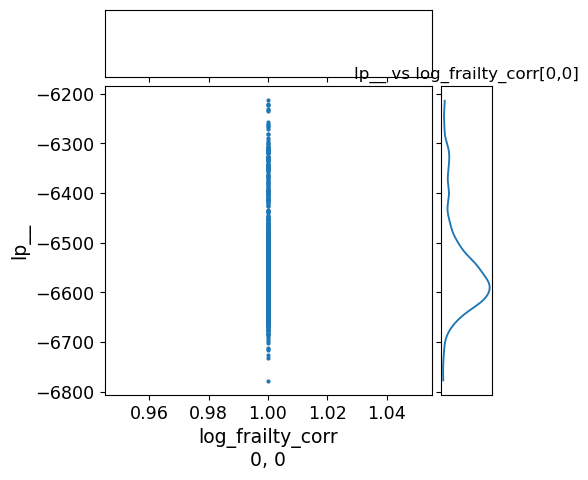

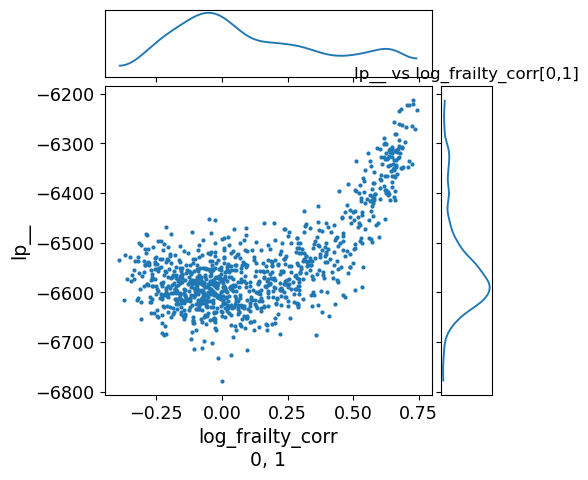

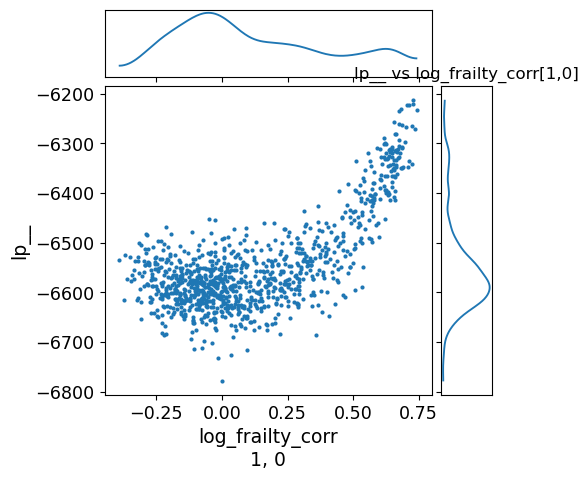

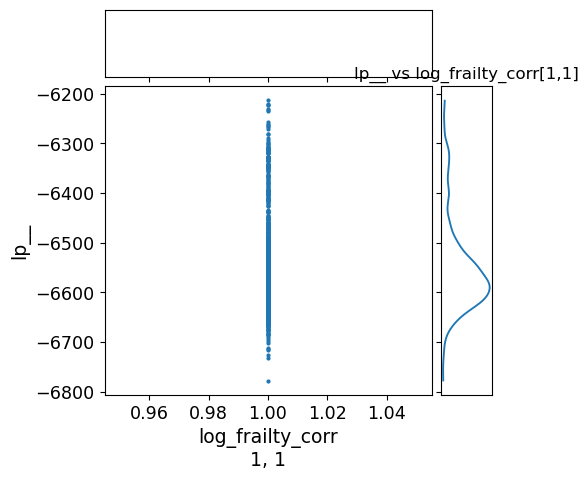

In [168]:

# List your parameter names
param_names = ["baseline_hazards", "betas", "log_frailty_scale", "log_frailty_corr"]
import xarray as xr

# Copy lp from sample_stats to posterior as lp__
idata.posterior = xr.merge([idata.posterior, idata.sample_stats[["lp"]].rename({"lp": "lp__"})])

for param in param_names:
    values = idata.posterior[param]
    param_dims = values.dims[2:]  # skip chain and draw
    param_coords = {dim: values.coords[dim].values for dim in param_dims}
    ndim = len(param_dims)

    if ndim == 0:
        # Scalar parameter
        az.plot_pair(
            idata,
            var_names=[param, "lp__"],
            kind="scatter",
            marginals=True,
            figsize=(5, 5),
        )
        plt.title(f"lp__ vs {param}")
        plt.show()
    elif ndim == 1:
        # 1D parameter (vector)
        dim = param_dims[0]
        for idx, coord in enumerate(param_coords[dim]):
            az.plot_pair(
                idata,
                var_names=[param, "lp__"],
                coords={dim: [coord]},
                kind="scatter",
                marginals=True,
                figsize=(5, 5),
            )
            plt.title(f"lp__ vs {param}[{coord}]")
            plt.show()
    elif ndim == 2:
        # 2D parameter (matrix)
        dim0, dim1 = param_dims
        for i, coord0 in enumerate(param_coords[dim0]):
            for j, coord1 in enumerate(param_coords[dim1]):
                az.plot_pair(
                    idata,
                    var_names=[param, "lp__"],
                    coords={dim0: [coord0], dim1: [coord1]},
                    kind="scatter",
                    marginals=True,
                    figsize=(5, 5),
                )
                plt.title(f"lp__ vs {param}[{coord0},{coord1}]")
                plt.show()

True baseline hazards: [0.1, 0.2]


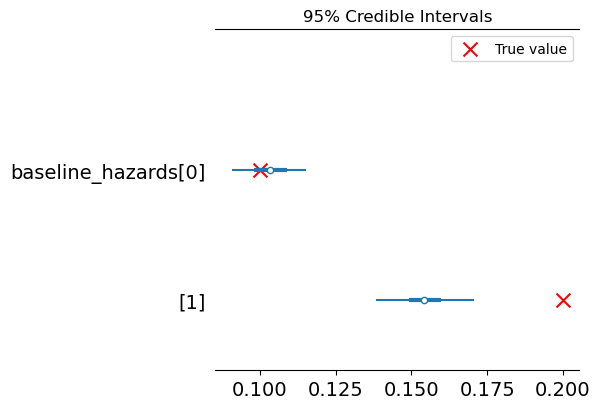

True beta coefficients: [[0. 0.]
 [0. 0.]]


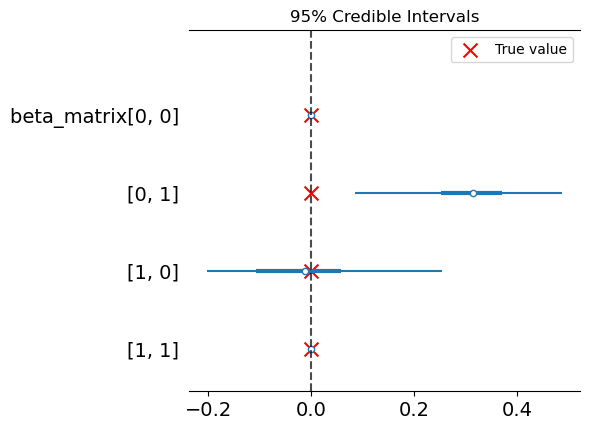

In [14]:
print(f"True baseline hazards: {baseline_hazards}")
axes = az.plot_forest(idata, var_names=["baseline_hazards"], 
                      hdi_prob=0.95, combined=True)
ax = axes[0] if isinstance(axes, (list, np.ndarray)) else axes
yticks = ax.get_yticks()
for i, val in enumerate(baseline_hazards[::-1]):
    ax.scatter(val, yticks[i], marker='x', color='red', s=100, label='True value' if i == 0 else "")
if len(baseline_hazards) > 0:
    ax.legend(loc='best')
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

print(f"True beta coefficients: {beta_mat}")
axes = az.plot_forest(idata, var_names=["beta_matrix"], 
                      hdi_prob=0.95, combined=True)
ax = axes[0] if isinstance(axes, (list, np.ndarray)) else axes
plt.axvline(0, color='black', linestyle='--', alpha=0.7)
yticks = ax.get_yticks()
for i, val in enumerate(beta_mat.flatten()[::-1]):
    ax.scatter(val, yticks[i], marker='x', color='red', s=100, label='True value' if i == 0 else "")
if beta_mat.size > 0:
    ax.legend(loc='best')
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

In [170]:
idata = az.from_cmdstanpy(posterior=fit)
# Now you can calculate WAIC and LOO
waic = az.waic(idata)
loo = az.loo(idata)

print(waic)
print(loo)

Computed from 1000 posterior samples and 1000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -5670.87    53.57
p_waic      209.66        -
Computed from 1000 posterior samples and 1000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -5669.62    53.56
p_loo      208.41        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.67]   (good)     1000  100.0%
   (0.67, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



In [171]:
no_frailty_model = CmdStanModel(
    stan_file= STAN_DIR / "multiplex_serology.stan"
)

no_frailty_fit = no_frailty_model.sample(
    data=stan_data,
    chains=chains,
    iter_sampling=iter_sampling,
    iter_warmup=iter_warmup,
    parallel_chains=parallel_chains,
    seed=seed,
    max_treedepth=max_treedepth,
    show_progress=True,
    show_console=False
)

no_frailty_idata = az.from_cmdstanpy(posterior=no_frailty_fit)
# Calculate WAIC and LOO for the no-frailty model
no_frailty_waic = az.waic(no_frailty_idata)
no_frailty_loo = az.loo(no_frailty_idata)
print(no_frailty_waic)
print(no_frailty_loo)

14:14:22 - cmdstanpy - INFO - CmdStan start processing


chain 1 |          | 00:00 Status

chain 2 |          | 00:00 Status

chain 3 |          | 00:00 Status

chain 4 |          | 00:00 Status

14:37:49 - cmdstanpy - INFO - CmdStan done processing.



Computed from 1000 posterior samples and 1000 observations log-likelihood matrix.

          Estimate       SE
elpd_waic -5669.77    53.53
p_waic      209.58        -
Computed from 1000 posterior samples and 1000 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -5668.47    53.52
p_loo      208.29        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.67]   (good)     1000  100.0%
   (0.67, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



True baseline hazards: [0.1, 0.2]


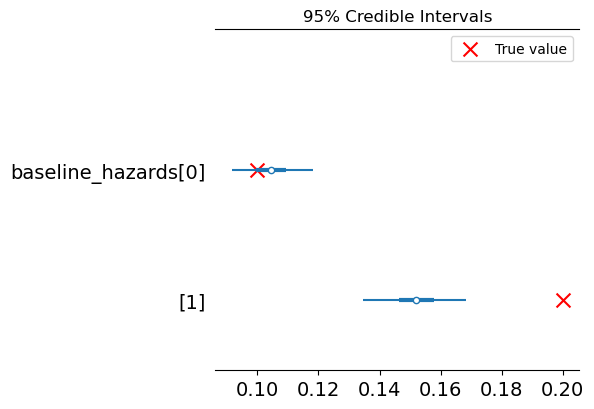

True beta coefficients: [[-0.         -0.70241087]
 [ 0.          0.        ]]


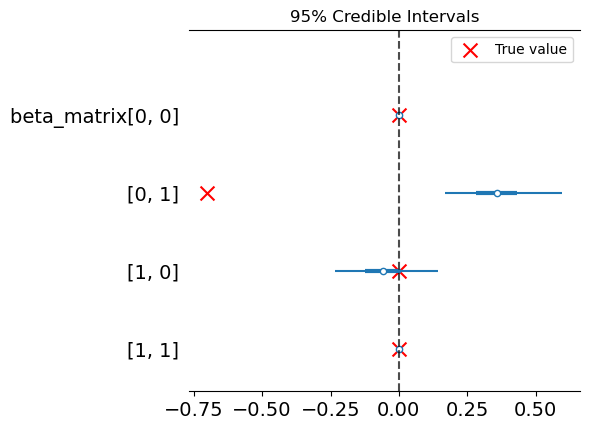

In [172]:
print(f"True baseline hazards: {baseline_hazards}")
axes = az.plot_forest(no_frailty_idata, var_names=["baseline_hazards"], 
                      hdi_prob=0.95, combined=True)
ax = axes[0] if isinstance(axes, (list, np.ndarray)) else axes
yticks = ax.get_yticks()
for i, val in enumerate(baseline_hazards[::-1]):
    ax.scatter(val, yticks[i], marker='x', color='red', s=100, label='True value' if i == 0 else "")
if len(baseline_hazards) > 0:
    ax.legend(loc='best')
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()

print(f"True beta coefficients: {beta_mat}")
axes = az.plot_forest(no_frailty_idata, var_names=["beta_matrix"], 
                      hdi_prob=0.95, combined=True)
ax = axes[0] if isinstance(axes, (list, np.ndarray)) else axes
plt.axvline(0, color='black', linestyle='--', alpha=0.7)
yticks = ax.get_yticks()
for i, val in enumerate(beta_mat.flatten()[::-1]):
    ax.scatter(val, yticks[i], marker='x', color='red', s=100, label='True value' if i == 0 else "")
if beta_mat.size > 0:
    ax.legend(loc='best')
plt.title("95% Credible Intervals")
plt.tight_layout()
plt.show()